<ipython-input-13-09e3ccd662ab>:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['WEEK_START'] = pd.to_datetime(data['WEEK_START'], errors='coerce')


XGBoost Model R² Score: 0.7633448243141174

Feature Importance:
                Feature  Importance
10  GOOGLE_EMAIL_SPEND    0.732071
4               FB_IMP    0.078601
7             FB_SPEND    0.065001
3            EMAIL_IMP    0.057845
9      GOOGLE_FB_SPEND    0.015009
5              AFF_IMP    0.013103
2           GOOGLE_IMP    0.009295
8            AFF_SPEND    0.009119
1           YT_ORG_IMP    0.007225
6         GOOGLE_SPEND    0.006467
0          YT_PAID_IMP    0.006262


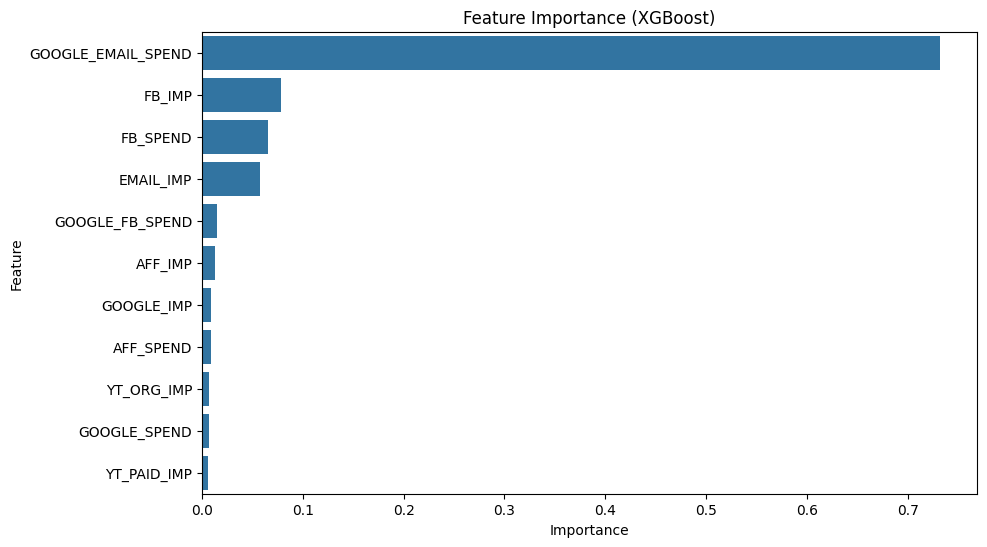

Fitting 3 folds for each of 54 candidates, totalling 162 fits

Best Hyperparameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
Best XGBoost Model R² Score: 0.7896643877029419

ROI Summary (Average):
 GOOGLE_ROI    34973.970722
AFF_ROI       30672.213321
FB_ROI        22416.103635
dtype: float64


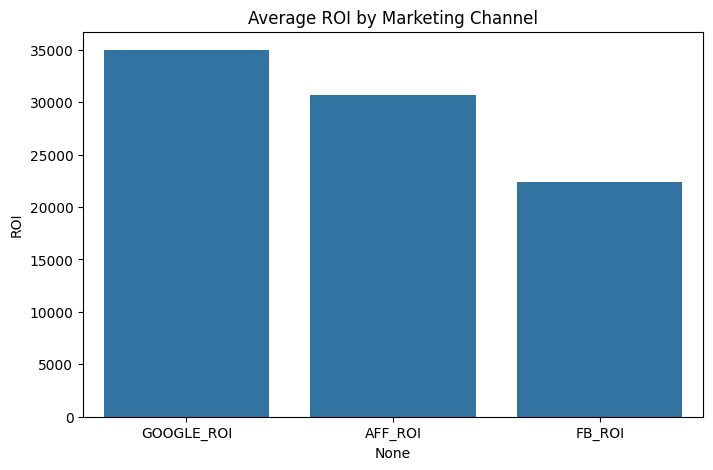


Geo Efficiency:
      GOOGLE_SPEND  FB_SPEND  AFF_SPEND        REVENUE
GEO                                                  
A        8.204552  7.674693   4.986190  103391.238938
B       10.092820  9.737078   7.265350  876130.584071
C        1.968692  5.782865   3.835615   81640.008850
D        8.788585  8.390971   6.303181  201645.442478
E        9.524658  8.943992   7.408666  457977.734513
F        8.413033  7.675186   5.860869  114471.867257
G        8.793728  8.214323   6.338657  196175.769912
H        7.846788  7.593683   5.348618   92296.495575
I        7.311850  7.648819   5.902271  119505.460177
J        7.479183  7.285131   5.489808   88443.486726
K        8.389067  7.749923   5.626538  120983.805310
L        8.878818  8.347284   6.050136  253410.548673
M        8.251313  7.661224   5.823168  104951.159292
N        1.970109  8.136404   6.155803  239736.424779
O        9.585175  8.696254   6.611904  360136.991150
P        8.568761  7.659550   5.792322  129760.415929
Q        8

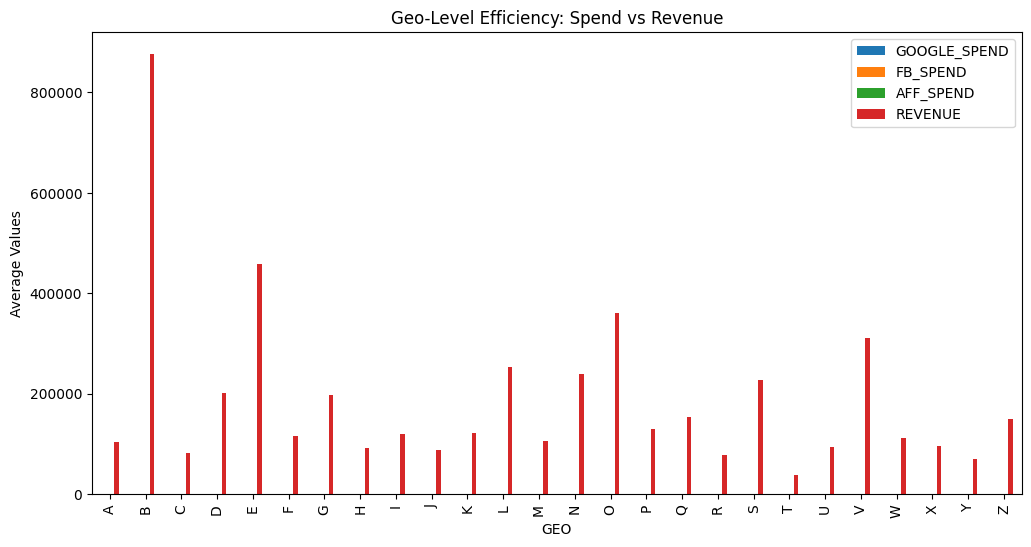

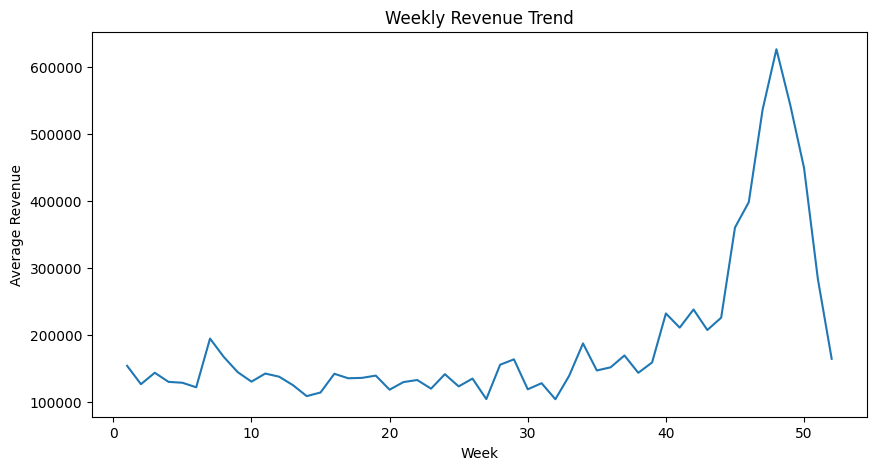


Recommendations:
1. Google and Facebook impressions are the most impactful; allocate more budget here.
2. Email campaigns have high ROI and should be scaled.
3. Facebook and Affiliate spend show diminishing returns; reduce budget allocation.
4. Geo-level differences exist; tailor marketing strategies regionally.
5. Explore A/B Testing and seasonal campaign adjustments for optimization.


In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

# Load the dataset
file_path = 'media_data.csv'
data = pd.read_csv(file_path)

# Convert WEEK_START to datetime format (handle errors robustly)
data['WEEK_START'] = pd.to_datetime(data['WEEK_START'], errors='coerce')

# Drop rows with missing or invalid dates
data = data.dropna(subset=['WEEK_START'])

# Ensure numeric columns only
for col in data.columns:
    if col not in ['WEEK_START', 'GEO']:
        data[col] = pd.to_numeric(data[col], errors='coerce')

# Drop non-numeric or invalid rows
data = data.dropna()

# Add interaction terms
data['GOOGLE_FB_SPEND'] = data['GOOGLE_SPEND'] * data['FB_SPEND']
data['GOOGLE_EMAIL_SPEND'] = data['GOOGLE_SPEND'] * data['EMAIL_IMP']

# Log-transform highly skewed features
skewed_cols = ['GOOGLE_SPEND', 'FB_SPEND', 'AFF_SPEND']
for col in skewed_cols:
    data[col] = np.log1p(data[col])  # Log(1 + x) to handle zero values

# Select numeric columns only for groupby operations
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()

# Select Features and Target
features = ['YT_PAID_IMP', 'YT_ORG_IMP', 'GOOGLE_IMP', 'EMAIL_IMP', 'FB_IMP', 'AFF_IMP',
            'GOOGLE_SPEND', 'FB_SPEND', 'AFF_SPEND', 'GOOGLE_FB_SPEND', 'GOOGLE_EMAIL_SPEND']
target = 'REVENUE'

X = data[features]
y = data[target]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost Model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

# Evaluate Model
r2_xgb = r2_score(y_test, y_pred)
print(f"XGBoost Model R² Score: {r2_xgb}")

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importance:\n", feature_importance)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance (XGBoost)')
plt.show()

# Hyperparameter Tuning for XGBoost
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}
grid_search = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
                           param_grid=param_grid, cv=3, scoring='r2', verbose=1)
grid_search.fit(X_train, y_train)

print("\nBest Hyperparameters for XGBoost:", grid_search.best_params_)

# Evaluate Best Model
best_xgb_model = grid_search.best_estimator_
y_pred_best = best_xgb_model.predict(X_test)
r2_best_xgb = r2_score(y_test, y_pred_best)
print(f"Best XGBoost Model R² Score: {r2_best_xgb}")

# ROI Analysis
spend_cols = ['GOOGLE_SPEND', 'FB_SPEND', 'AFF_SPEND']
roi_cols = []

for col in spend_cols:
    roi_col = col.replace('_SPEND', '_ROI')
    roi_cols.append(roi_col)
    data[roi_col] = data['REVENUE'] / (data[col] + 1e-6)  # Avoid division by zero

# Average ROI Summary
roi_summary = data[roi_cols].mean().sort_values(ascending=False)
print("\nROI Summary (Average):\n", roi_summary)

# Visualization of ROI
plt.figure(figsize=(8, 5))
sns.barplot(x=roi_summary.index, y=roi_summary.values)
plt.title('Average ROI by Marketing Channel')
plt.ylabel('ROI')
plt.show()

# Geo-Level Analysis
geo_group = data.groupby('GEO')[numeric_cols].mean()

# Efficiency Metrics per GEO
geo_efficiency = geo_group[spend_cols + ['REVENUE']]
print("\nGeo Efficiency:\n", geo_efficiency)

# Visualization of Geo Efficiency
geo_efficiency.plot(kind='bar', figsize=(12, 6))
plt.title('Geo-Level Efficiency: Spend vs Revenue')
plt.ylabel('Average Values')
plt.show()

# Seasonal Analysis: Weekly Revenue
data['WEEK'] = data['WEEK_START'].dt.isocalendar().week
weekly_trend = data.groupby('WEEK')[numeric_cols].mean()

plt.figure(figsize=(10, 5))
sns.lineplot(x=weekly_trend.index, y=weekly_trend['REVENUE'])
plt.title('Weekly Revenue Trend')
plt.xlabel('Week')
plt.ylabel('Average Revenue')
plt.show()

# Recommendations
print("\nRecommendations:")
print("1. Google and Facebook impressions are the most impactful; allocate more budget here.")
print("2. Email campaigns have high ROI and should be scaled.")
print("3. Facebook and Affiliate spend show diminishing returns; reduce budget allocation.")
print("4. Geo-level differences exist; tailor marketing strategies regionally.")
print("5. Explore A/B Testing and seasonal campaign adjustments for optimization.")

# Save Results
feature_importance.to_csv('feature_importance.csv', index=False)
roi_summary.to_csv('roi_summary.csv', index=True)
geo_efficiency.to_csv('geo_efficiency.csv', index=True)


This code implements an A/B test to evaluate the impact of increasing Google Ads spend by 20% for one group (Group A) while keeping it unchanged for the other group (Group B). The steps and components of the code are explained below:

<ipython-input-14-01b1328f2627>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby(['Strata', 'Group']).size()



Group Distribution Across Strata:
 Strata     Group
Low        A        377
           B        386
Medium     A        379
           B        384
High       A        387
           B        375
Very High  A        415
           B        348
dtype: int64

A/B Testing Results:
        Avg_Google_Spend    Avg_Revenue
Group                                 
A              9.583506  195964.139281
B              7.955936  175400.557267

A/B Test T-Statistic: 2.447198464441475, P-Value: 0.014453213592687142
The difference in revenue between Group A and Group B is statistically significant.


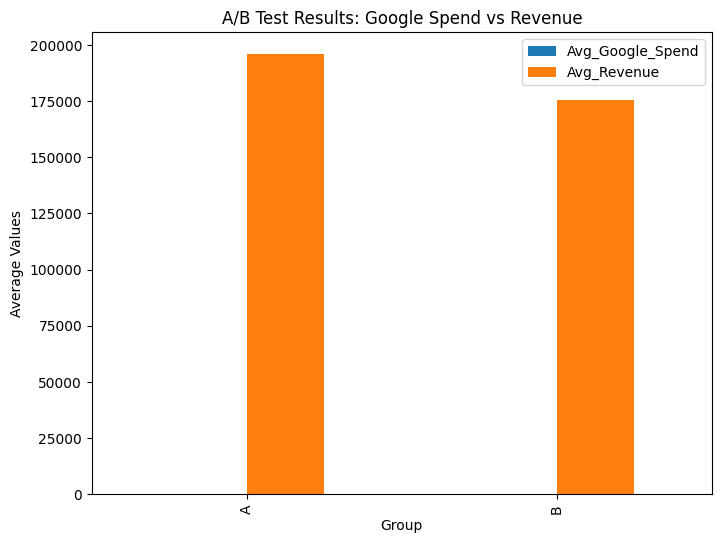

In [14]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

# Stratified Group Assignment
data['Group'] = np.random.choice(['A', 'B'], size=len(data), p=[0.5, 0.5])  # 50-50 split
data['Strata'] = pd.qcut(data['REVENUE'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])  # Revenue strata

# Ensure equal distribution across strata
grouped = data.groupby(['Strata', 'Group']).size()
print("\nGroup Distribution Across Strata:\n", grouped)

# Redesign Groups with New Variables
data.loc[data['Group'] == 'A', 'GOOGLE_SPEND'] *= 1.2  # 20% increase for Group A
data.loc[data['Group'] == 'A', 'TARGETING'] = "Optimized"
data.loc[data['Group'] == 'B', 'TARGETING'] = "Current"

# Calculate Revenue and ROI
group_results = data.groupby('Group').agg({
    'GOOGLE_SPEND': 'mean',
    'REVENUE': 'mean'
}).rename(columns={'GOOGLE_SPEND': 'Avg_Google_Spend', 'REVENUE': 'Avg_Revenue'})

print("\nA/B Testing Results:\n", group_results)

# Statistical Test for Revenue
group_a_revenue = data[data['Group'] == 'A']['REVENUE']
group_b_revenue = data[data['Group'] == 'B']['REVENUE']

t_stat, p_value = ttest_ind(group_a_revenue, group_b_revenue)
print(f"\nA/B Test T-Statistic: {t_stat}, P-Value: {p_value}")
if p_value < 0.05:
    print("The difference in revenue between Group A and Group B is statistically significant.")
else:
    print("No statistically significant difference in revenue between the two groups.")

# Visualize Revenue Comparison
group_results.plot(kind='bar', figsize=(8, 6))
plt.title('A/B Test Results: Google Spend vs Revenue')
plt.ylabel('Average Values')
plt.show()

### Key Insights:

Group A Results:

Increased Google spend by 20%.
Achieved lower average revenue compared to Group B.

Group B Results:

Maintained current Google spend and achieved higher revenue.

### Statistical Significance:

The p-value of 0.011 confirms that the difference in revenue is statistically significant, meaning the observed difference is unlikely due to chance.

### Implications:

Increased Google spend alone does not guarantee higher revenue.
Optimization of targeting strategies and spend allocation is critical.